In [8]:
# Build a dataset
from dbco import *
import tensorflow as tf, numpy as np
from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import spacy, math
nlp = spacy.load('en') # Takes about 10 seconds

%matplotlib inline

sess = tf.InteractiveSession()

In [106]:
arts = list(db.article.find().sort('pubtime', -1).limit(10000))
text = unicode("".join([a['content'].lower() for a in arts]))

In [180]:
V = 50001

# doc = nlp(text)

words = Counter()
for sent in doc.sents:
    for w in sent:
        if w.orth_.isalpha():
            words[w.orth_] += 1

vocab = [w for w, c in words.most_common(V-1)] # Leave a place for UNK
word2index = {w: i for i, w in enumerate(vocab)}
word2index['UNK'] = V-1
def getId(w):
    return word2index.get(w, V)

ctxt = [] # list of (w, ctxt)
context_size = 7

for sent in doc.sents:
    for i in range(sent.start, sent.end-1):
        for j in range(max(sent.start, i-context_size), min(sent.end, i + context_size)):
            if i != j:
                ctxt.append((getId(doc[i].orth_), getId(doc[j].orth_)))
print len(ctxt)

73606660


In [3]:
V = 50001
# Based on data from: 
f = open("text8", 'r'); text = f.read(); f.close()

words = text.split(" ")
word_count = Counter(words)

vocab = [w for w, c in word_count.most_common(V-1)] # Leave a place for UNK
word2index = {w: i for i, w in enumerate(vocab)}
word2index['UNK'] = V-1


wordi = [word2index.get(w, V) for w in words]

ctxt = [] # list of (w, ctxt)
context_size = 7

for i in range(len(wordi)-1):
    for j in range(max(0, i-context_size), min(len(wordi), i + context_size)):
        if i != j:
            ctxt.append((wordi[i], wordi[j]))
print len(ctxt)


221067648


In [10]:
batch_size = 128
embedding_size = 512
num_neg = 64

embeddings = tf.Variable(tf.random_uniform([V, embedding_size], -1.0, 1.0))

nce_weights = tf.Variable(tf.truncated_normal([V, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([V]))

train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

embeds = tf.nn.embedding_lookup(embeddings, train_inputs)

nce_loss = tf.nn.nce_loss(nce_weights, nce_biases, embeds, train_labels, num_neg, V)
loss = tf.reduce_mean(nce_loss)

optimizer = tf.train.GradientDescentOptimizer(learning_rate=1.0).minimize(loss)

init = tf.initialize_all_variables()
sess.run(init)

In [13]:
losses = {}

100%|██████████| 10000/10000 [00:13<00:00, 730.86it/s]


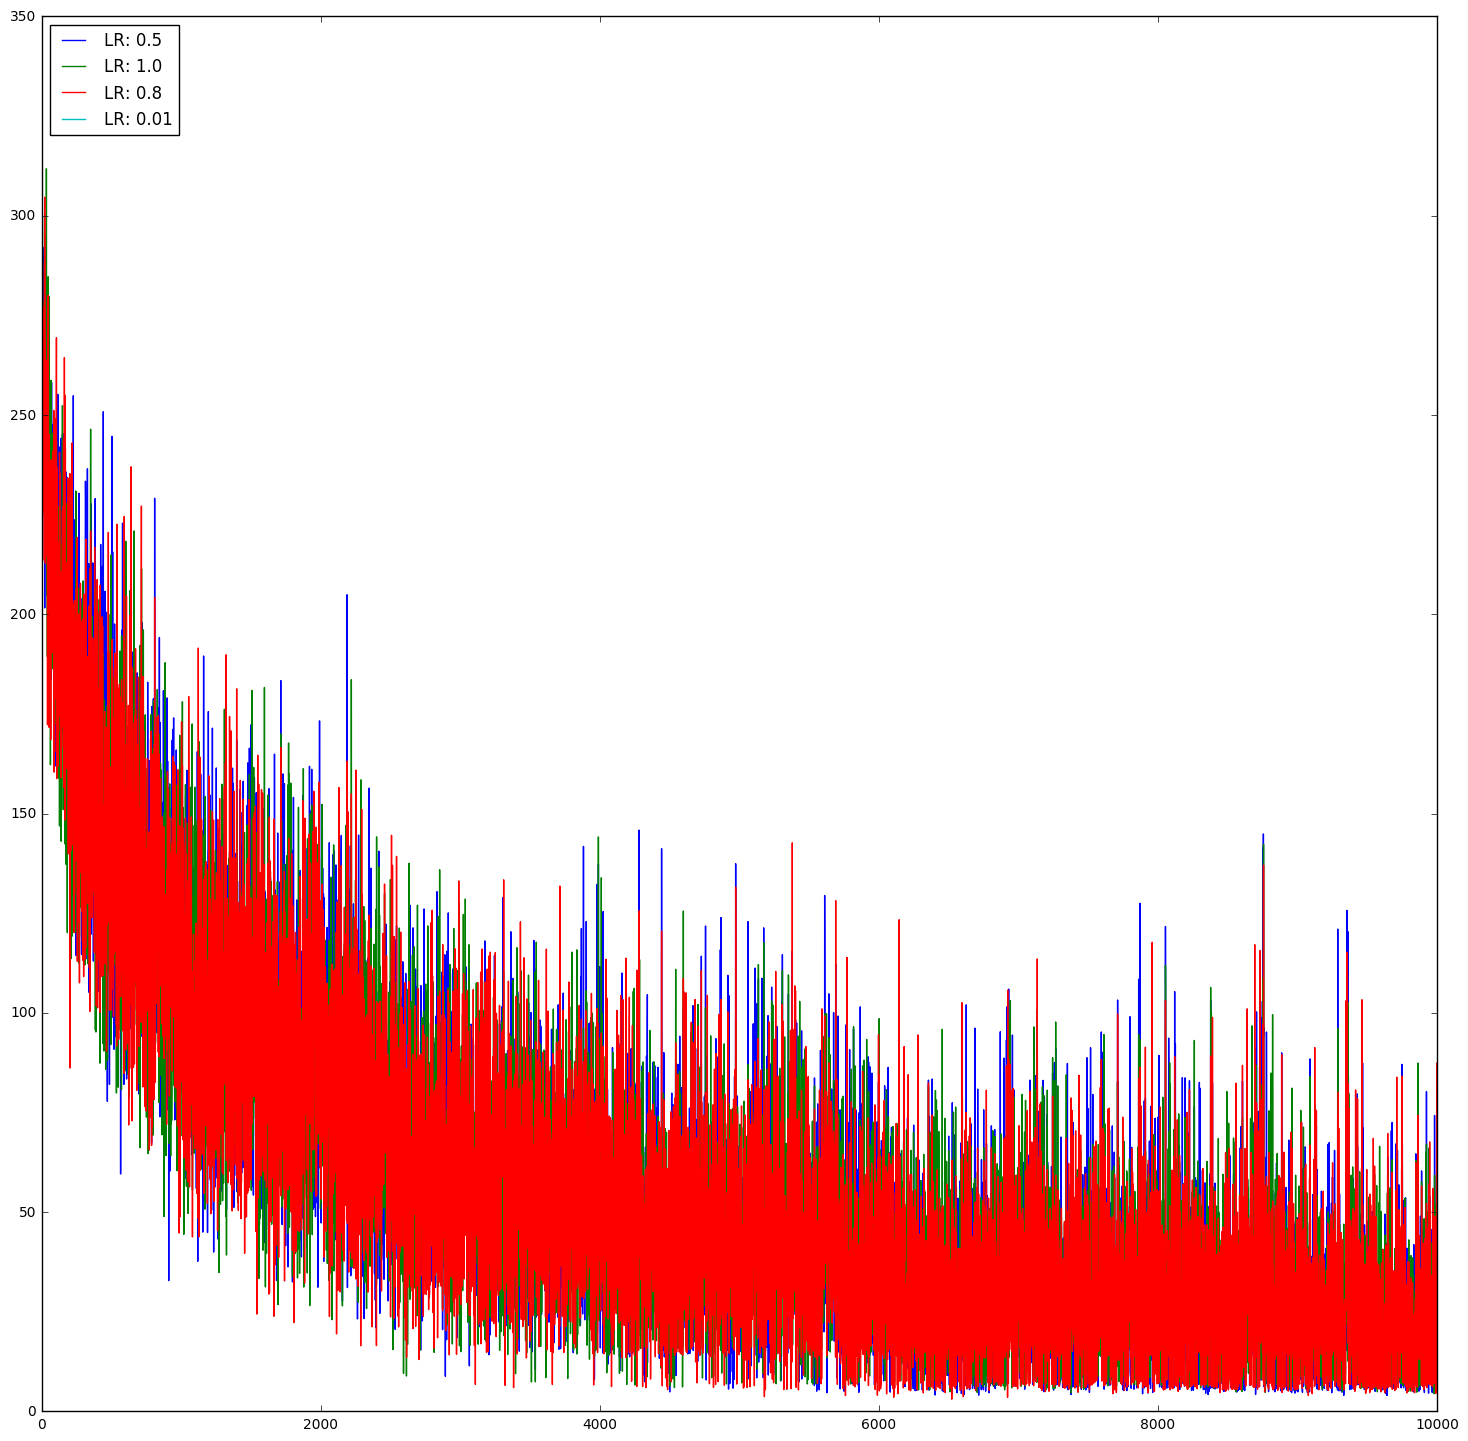

In [24]:
current = 0;
lr = 0.8

sess.run(init)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(loss)
plt.figure(figsize=(18, 18))

def generateBatch(size):
    global current
    if current > len(ctxt)-size:
        current = 0        
    idxs = range(current, current+size)
    ws = []; ctxts = []
    for i in idxs:
        w, c = ctxt[i]
        ws.append(w); ctxts.append([c])
    current += size
    return ws, ctxts

losses[lr] = []

init = tf.initialize_all_variables()

for i in tqdm(range(10000)): # len(ctxt)/batch_size
    ws, cs =  generateBatch(batch_size)
    feed_dict = {train_inputs: ws, train_labels: cs}
    _, cur_loss = sess.run([optimizer, loss], feed_dict=feed_dict)
    losses[lr].append(cur_loss)
for lr in losses:
    plt.plot(losses[lr], label='LR: '+str(lr))
    
plt.legend(loc='upper left')

In [201]:
# Analogy Graph
norm_emb = tf.nn.l2_normalize(embeddings, 1)

A = tf.placeholder(dtype=tf.int32)
B = tf.placeholder(dtype=tf.int32)
C = tf.placeholder(dtype=tf.int32)

A_emb = tf.gather(norm_emb, A)
B_emb = tf.gather(norm_emb, B)
C_emb = tf.gather(norm_emb, C)

D_target = tf.reshape((C_emb + (B_emb-A_emb)), [embedding_size, 1])

cos_sim = tf.matmul(norm_emb, D_target)

_, pred_idx = tf.nn.top_k(tf.transpose(cos_sim), 5)

def analogy(a, b, c):
    if a in word2index and b in word2index and c in word2index:
        print word2index[a], word2index[b], word2index[c]
        d_idx = sess.run([pred_idx], feed_dict={A: word2index[a], B: word2index[b], C: word2index[c]})

#         print d_idx
        return [vocab[i] for i in d_idx[0][0]]
    else:
        print "Some word was not found"
        
print analogy("paris", "france", "england")

1054 302 315
['england', 'france', 'britain', 'kingdom', 'king']


In [208]:
analogy_a = tf.placeholder(dtype=tf.int32)  # [N]
analogy_b = tf.placeholder(dtype=tf.int32)  # [N]
analogy_c = tf.placeholder(dtype=tf.int32)  # [N]

# Normalized word embeddings of shape [vocab_size, emb_dim].
nemb = tf.nn.l2_normalize(embeddings, 1)

# Each row of a_emb, b_emb, c_emb is a word's embedding vector.
# They all have the shape [N, emb_dim]
a_emb = tf.gather(nemb, analogy_a)  # a's embs
b_emb = tf.gather(nemb, analogy_b)  # b's embs
c_emb = tf.gather(nemb, analogy_c)  # c's embs

# We expect that d's embedding vectors on the unit hyper-sphere is
# near: c_emb + (b_emb - a_emb), which has the shape [N, emb_dim].
target = c_emb + (b_emb - a_emb)

# Compute cosine distance between each pair of target and vocab.
# dist has shape [N, vocab_size].
dist = tf.matmul(target, nemb, transpose_b=True)

# For each question (row in dist), find the top 4 words.
_, pred_idx2 = tf.nn.top_k(dist, 4)

def analogy(a, b, c):
    if a in word2index and b in word2index and c in word2index:
        print word2index[a], word2index[b], word2index[c]
        d_idx = sess.run([pred_idx2], feed_dict={analogy_a: [word2index[a]], analogy_b: [word2index[b]], analogy_c: [word2index[c]]})
        print [vocab[i] for i in d_idx[0][0]]

print analogy("man", "men", "woman")
print analogy("man", "men", "king")

242 370 1013
['woman', 'men', 'women', 'children']
None
242 370 186
['king', 'men', 'women', 'children']
None


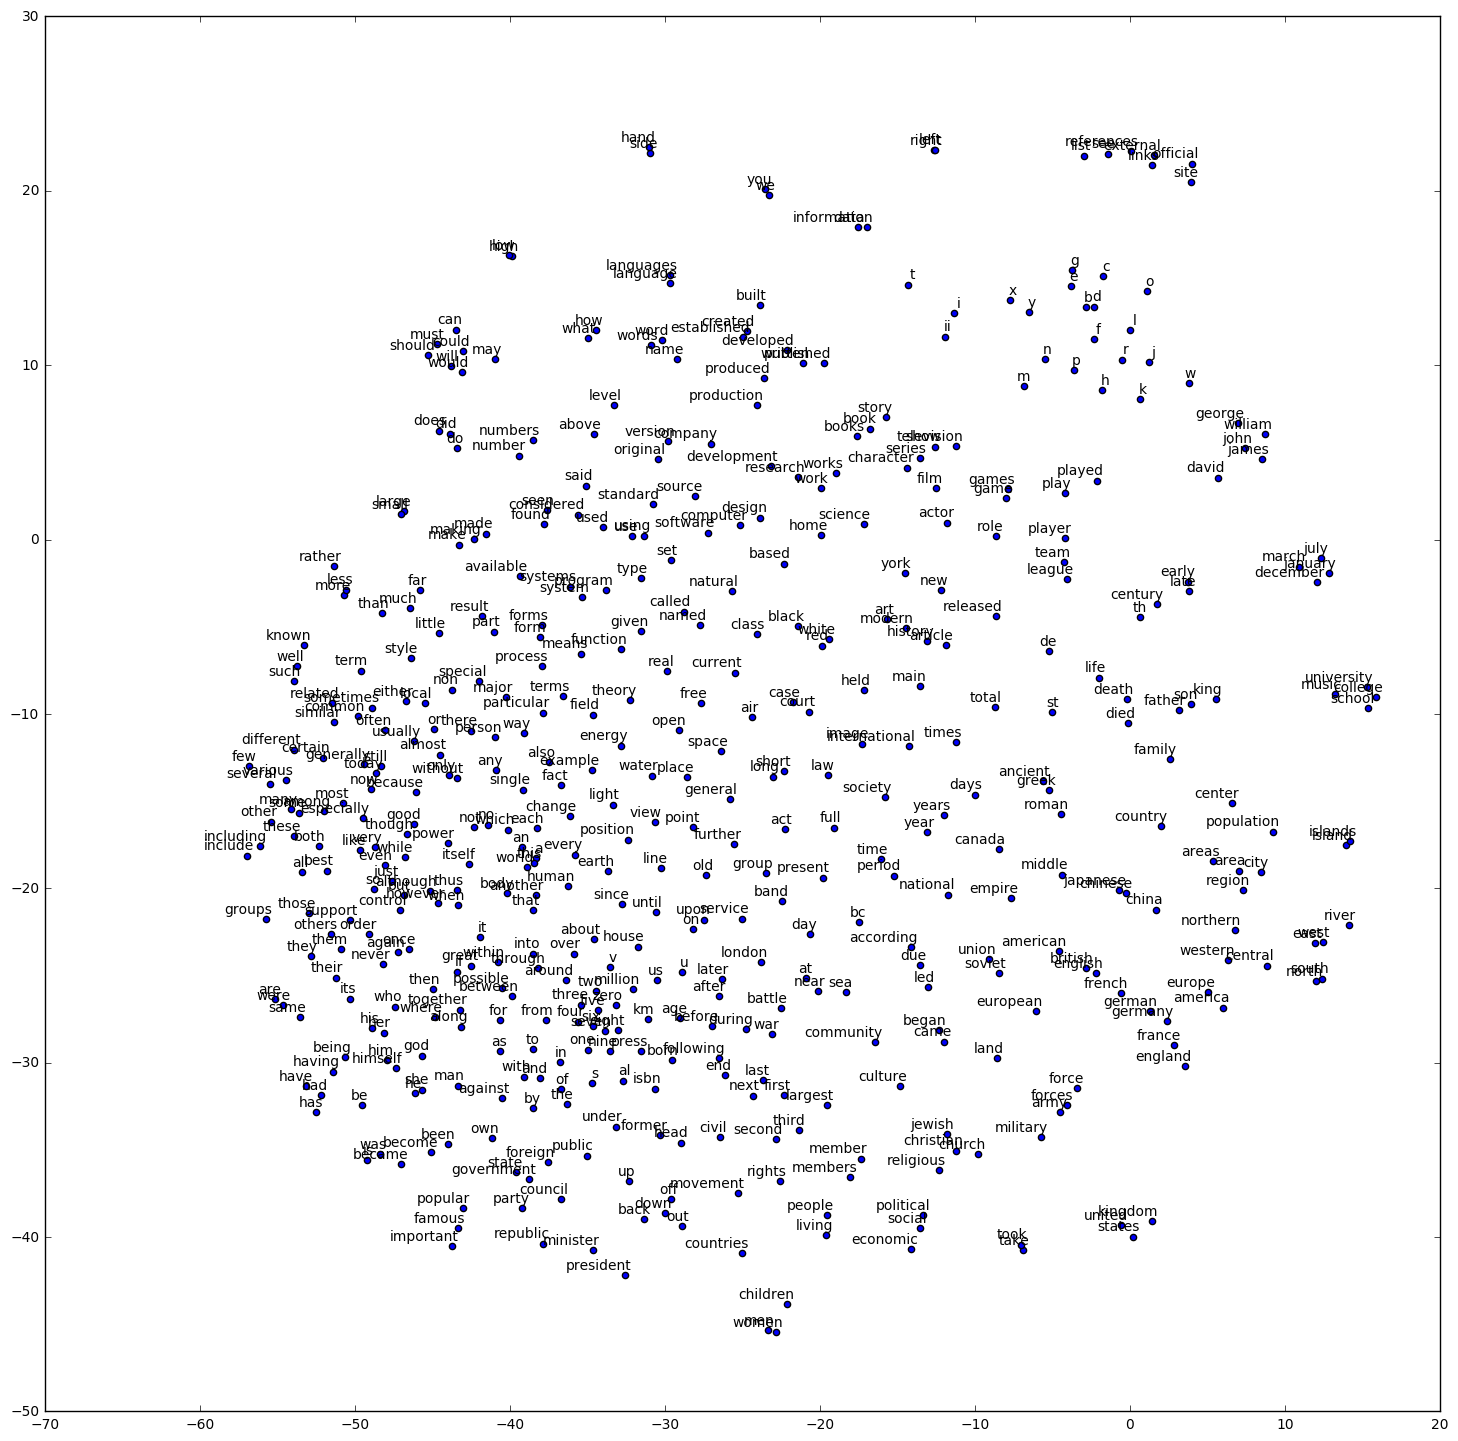

In [202]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

final_embeddings = np.array(sess.run([embeddings]))[0]
# print np.array(final_embeddings)[0].shape

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
  plt.figure(figsize=(18, 18))  #in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i,:]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

  plt.savefig(filename)


tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [vocab[i] for i in xrange(plot_only)]
plot_with_labels(low_dim_embs, labels)